# Finetune XLSR-wav2vec2 for Lingala

This notebook is adapted from Fine-tuning Xlsr-Wav2Vec2 for  ASR to train lingala ASR

## installs and imports

This notebook is implemented in jupyter notebook on Amazon ec2 V100 16GB

In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Nov 23 14:39:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   31C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import sys

In [5]:
# Install helper functions.
#!{sys.executable} -m pip install -q git+https://github.com/gmihaila/ml_things.git

In [6]:
#!{sys.executable} -m pip uninstall matplotlib -y

In [7]:
#!{sys.executable} -m pip install matplotlib==3.4.0

In [8]:
!{sys.executable} -m pip install datasets==1.13.3
!{sys.executable} -m pip install transformers==4.24.0
#4.11.3
!{sys.executable} -m pip install torchaudio
!{sys.executable} -m pip install librosa
!{sys.executable} -m pip install jiwer

  Using cached datasets-1.13.3-py3-none-any.whl (287 kB)
  Using cached huggingface_hub-0.0.19-py3-none-any.whl (56 kB)
ERROR: evaluate 0.1.0 has requirement huggingface-hub>=0.7.0, but you'll have huggingface-hub 0.0.19 which is incompatible.
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.11.0
    Uninstalling huggingface-hub-0.11.0:
      Successfully uninstalled huggingface-hub-0.11.0
  Attempting uninstall: datasets
    Found existing installation: datasets 2.0.0
    Uninstalling datasets-2.0.0:
      Successfully uninstalled datasets-2.0.0
     |████████████████████████████████| 5.5 MB 23.4 MB/s eta 0:00:01
  Using cached huggingface_hub-0.11.0-py3-none-any.whl (182 kB)
     |████████████████████████████████| 7.6 MB 59.6 MB/s eta 0:00:01
ERROR: datasets 1.13.3 has requirement huggingface-hub<0.1.0,>=0.0.19, but you'll have huggingface-hub 0.11.0 which is incompatible.
  Attempting uninstall: huggingface-hub
    Found existing installatio

# Data Preparation

Download or upload the data in a zip file from local machine

In [9]:
from huggingface_hub import notebook_login

notebook_login()


Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /home/ubuntu/.huggingface/token
Login successful


In [ ]:
!{sys.executable} -m pip install gdown -U --no-cache-dir

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/home/ubuntu/LingalaAudio-20221111T081505Z-001.zip", 'r')
zip_ref.extractall("/home/ubuntu/")
zip_ref.close()

extract to LingalaAudio

In [10]:
import numpy as np
import zipfile
import csv

## Load Dataset

We use our own collected dataset which contains 4.3 validated hours of lingala at approximately 578.0 MB. 

In [11]:
with open('/home/ubuntu/LingalaAudio/pyLingala-master/data/train.csv', newline='',encoding='UTF-8') as f:
      reader = csv.reader(f)
      data = list(reader)
      train_data = [data[i] for i in range(len(data)) if i!=0]

with open('/home/ubuntu/LingalaAudio/pyLingala-master/data/test.csv', newline='',encoding='UTF-8') as f:
      reader = csv.reader(f)
      data = list(reader)
      t_data = [data[i] for i in range(len(data)) if i!=0]

This seed is used to help other get the same result as us

In [12]:
#Get valid indices
import random
random.seed(42) #this seed was used specifically to compare with Okwugbe model



v = 300 #200 samples for valid. Change as you want
test_list = [i for i in range(len(t_data))]
valid_indices = random.choices(test_list, k=v)


test_data = [t_data[i] for i in range(len(t_data)) if i not in valid_indices]
valid_data = [t_data[i] for i in range(len(t_data)) if i in valid_indices]

create json files

In [13]:
def create_json_file(d):
  utterance = d[2]
  wav_path =d[0]
  wav_path = wav_path.replace("/home/ubuntu/organised_recording","/home/ubuntu/LingalaAudio/pyLingala-master")
  return {
      "path": wav_path,
      "sentence": utterance
  }

train_json = [create_json_file(i) for i in train_data]
test_json = [create_json_file(i) for i in test_data]
valid_json = [create_json_file(i) for i in valid_data]

In [14]:
import os

In [15]:
#Make folder to store files


train_path = '/home/ubuntu/model_output/lingala_xlsr2/train'
test_path = '/home/ubuntu/model_output/lingala_xlsr2/test'
valid_path = '/home/ubuntu/model_output/lingala_xlsr2/valid'

if not os.path.isdir(train_path):
  print("Creating paths")
  os.makedirs(train_path)
  os.makedirs(test_path)
  os.makedirs(valid_path)

Creating paths


In [16]:
import json
#for train
for i, sample in enumerate(train_json):
  file_path = os.path.join(train_path,'train_lingala_{}.json'.format(i))
  with open(file_path, 'w') as outfile:
    json.dump(sample, outfile)

#for test
for i, sample in enumerate(test_json):
  file_path = os.path.join(test_path,'test_lingala_{}.json'.format(i))
  with open(file_path, 'w') as outfile:
    json.dump(sample, outfile)

#for valid
for i, sample in enumerate(valid_json):
  file_path = os.path.join(valid_path,'valid_lingala_{}.json'.format(i))
  with open(file_path, 'w') as outfile:
    json.dump(sample, outfile)

In [17]:
#!{sys.executable} -m pip install ipywidgets


In [18]:
#!{sys.executable} -m jupyter nbextension enable --py widgetsnbextension

In [19]:
from ipywidgets import FloatProgress

#run the second time after the error
from datasets import load_dataset, load_metric

#for train
for root, dirs, files in os.walk(train_path):
  lingala_train = load_dataset("json", data_files=[os.path.join(root,i) for i in files],split="train")

#for test
for root, dirs, files in os.walk(test_path):
  lingala_test = load_dataset("json", data_files=[os.path.join(root,i) for i in files],split="train")

#for valid
for root, dirs, files in os.walk(valid_path):
  lingala_valid = load_dataset("json", data_files=[os.path.join(root,i) for i in files],split="train")

Resolving data files:   0%|          | 0/2465 [00:00<?, ?it/s]

Using custom data configuration default-5b4bbb83d4c5e582


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /home/ubuntu/.cache/huggingface/datasets/json/default-5b4bbb83d4c5e582/0.0.0/c2d554c3377ea79c7664b93dc65d0803b45e3279000f993c7bfd18937fd7f426. Subsequent calls will reuse this data.


Resolving data files:   0%|          | 0/180 [00:00<?, ?it/s]

Using custom data configuration default-7a8e1420f5666976


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /home/ubuntu/.cache/huggingface/datasets/json/default-7a8e1420f5666976/0.0.0/c2d554c3377ea79c7664b93dc65d0803b45e3279000f993c7bfd18937fd7f426. Subsequent calls will reuse this data.


Resolving data files:   0%|          | 0/204 [00:00<?, ?it/s]

Using custom data configuration default-8c0e7fa92da612c3


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /home/ubuntu/.cache/huggingface/datasets/json/default-8c0e7fa92da612c3/0.0.0/c2d554c3377ea79c7664b93dc65d0803b45e3279000f993c7bfd18937fd7f426. Subsequent calls will reuse this data.


## Exploration of the data

In [20]:
lingala_test

Dataset({
    features: ['path', 'sentence'],
    num_rows: 180
})

In [21]:
#show random sentences
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    print(len(dataset))
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [22]:
show_random_elements(lingala_test, num_examples=20)

180


,path,sentence
0,/home/ubuntu/LingalaAudio/pyLingala-master/data/test/wav/joe/220716-083749_lin_9f7_elicit_47.wav,amoni elongi ya mama na bango akufa motema na ye ekiti
1,/home/ubuntu/LingalaAudio/pyLingala-master/data/test/wav/garcongina/220719-141705_lin_9f7_elicit_134.wav,soki kaka polele pawu
2,/home/ubuntu/LingalaAudio/pyLingala-master/data/test/wav/yan2/220717-135652_lin_9f7_elicit_94.wav,nyɔnso wana ezosalama tshotsho kodiongo pe azoyeba te
3,/home/ubuntu/LingalaAudio/pyLingala-master/data/test/wav/v/220716-105601_lin_9f7_elicit_90.wav,afandi mwa kimya azongisi mokongo na nsima
4,/home/ubuntu/LingalaAudio/pyLingala-master/data/test/wav/garcongina/220719-141705_lin_9f7_elicit_111.wav,akobi na kolobaka ete soki bobwakisi ngai bokotiya nani
5,/home/ubuntu/LingalaAudio/pyLingala-master/data/test/wav/yan2/220717-135652_lin_9f7_elicit_82.wav,po ndelo oyɔ mwananyoka abongisaki ndako wana oza na likanisi te
6,/home/ubuntu/LingalaAudio/pyLingala-master/data/test/wav/deborah/220718-132354_lin_9f7_elicit_9.wav,mawa esunda pongi eyingela olongwa susi na ngai
7,/home/ubuntu/LingalaAudio/pyLingala-master/data/test/wav/garcongina/220719-141705_lin_9f7_elicit_124.wav,bato bazalaki kokεngεla ye basutuka
8,/home/ubuntu/LingalaAudio/pyLingala-master/data/test/wav/garcongina/220719-141705_lin_9f7_elicit_113.wav,na ndenge ya respect petit tangu akoti na esika bakulutu bazali ezosenga mwa nsamba ekita
9,/home/ubuntu/LingalaAudio/pyLingala-master/data/test/wav/v/220716-105601_lin_9f7_elicit_97.wav,yɔka yɔ masolo ozalaka na yango


<AxesSubplot:>

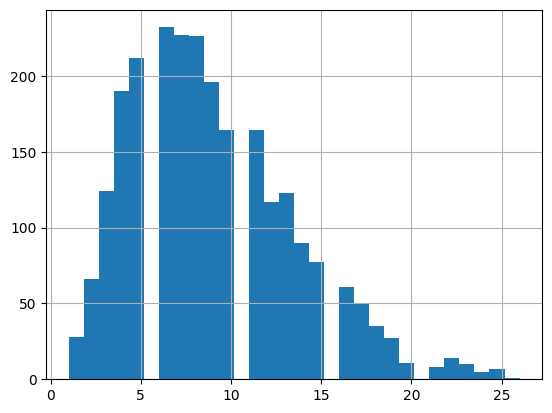

In [23]:
train_df = pd.DataFrame({'sentence':lingala_train['sentence']})
train_df['nb_words'] = train_df.sentence.map(lambda x: len(x.split()))
train_df.nb_words.hist(bins=30)

<AxesSubplot:>

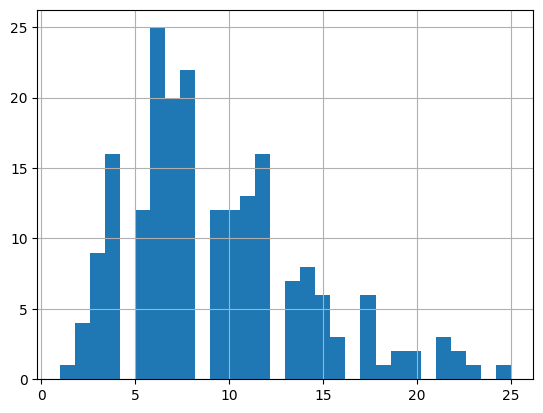

In [24]:
validation_df = pd.DataFrame({'sentence':lingala_valid['sentence']})
validation_df['nb_words'] = validation_df.sentence.map(lambda x: len(x.split()))
validation_df.nb_words.hist(bins=30)

<AxesSubplot:>

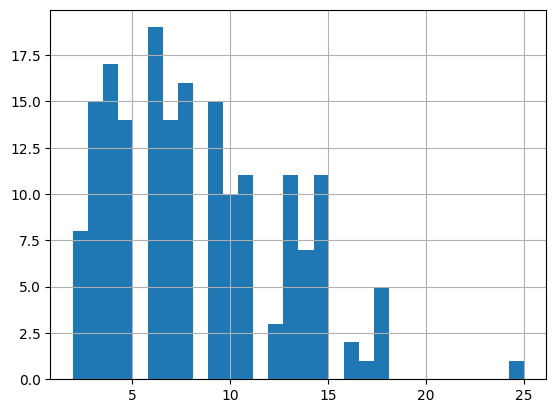

In [25]:
test_df = pd.DataFrame({'sentence':lingala_test['sentence']})
test_df['nb_words'] = test_df.sentence.map(lambda x: len(x.split()))
test_df.nb_words.hist(bins=30)

## Path ; wav files

In [ ]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

In [ ]:
from functools import partial
import pandas as pd
import numpy as np

import torchaudio

In [ ]:
SAMPLE_WAV = '/home/ubuntu/LingalaAudio/pyLingala-master/data/train/wav/betty/221011-125449_lin_359_elicit_0.wav'

In [ ]:
metadata = torchaudio.info(SAMPLE_WAV)
print(metadata)

In [ ]:
train_df = pd.DataFrame({'path':lingala_train['path']})
train_df['sample_rate'] = train_df.path.map(lambda x: torchaudio.info(x).sample_rate)
train_df['num_frames'] = train_df.path.map(lambda x: torchaudio.info(x).num_frames)
train_df['seconds'] = train_df.num_frames / train_df.sample_rate
train_df.seconds.hist(bins=30)

In [ ]:
validation_df = pd.DataFrame({'path':lingala_valid['path']})
validation_df['sample_rate'] = validation_df.path.map(lambda x: torchaudio.info(x).sample_rate)
validation_df['num_frames'] = validation_df.path.map(lambda x: torchaudio.info(x).num_frames)
validation_df['seconds'] = validation_df.num_frames / validation_df.sample_rate
validation_df.seconds.hist(bins=30)

In [ ]:
test_df = pd.DataFrame({'path':lingala_test['path']})
test_df['sample_rate'] = test_df.path.map(lambda x: torchaudio.info(x).sample_rate)
test_df['num_frames'] = test_df.path.map(lambda x: torchaudio.info(x).num_frames)
test_df['seconds'] = test_df.num_frames / test_df.sample_rate
test_df.seconds.hist(bins=30)

In [ ]:
# this code worked with the following torch setup
#!{sys.executable} -m pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [26]:
import torch
import torchvision
torch.cuda.get_device_name()

'Tesla V100-SXM2-16GB'

In [27]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�]'

def remove_special_characters(batch):
    batch["sentence"] = re.sub(chars_to_ignore_regex, '', batch["sentence"]).lower() + " "
    return batch

In [28]:
lingala_train = lingala_train.map(remove_special_characters)
lingala_test = lingala_test.map(remove_special_characters)
lingala_valid = lingala_valid.map(remove_special_characters)

Parameter 'function'=<function remove_special_characters at 0x7f8518c0a4c0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/2465 [00:00<?, ?ex/s]

  0%|          | 0/180 [00:00<?, ?ex/s]

  0%|          | 0/204 [00:00<?, ?ex/s]

In [29]:
show_random_elements(lingala_train.remove_columns(["path"]))

2465


,sentence
0,fkm azwaki visa ya ba touristes mpo na sanza moko
1,likofi na libumu
2,akomaki mwa mɔtɔ ye nde mɔtɔ akomaki kosukola basani
3,mbote tata mokonzi
4,djef azalaki mokongo mpe marielouise azala moluba
5,ntango wana miraesa atindi moninga na ye moko akεndε koyebisa baboti ya fkm
6,fkm ayɔki nzutu
7,ngai nde mokonzi ya ekolo
8,na mboka eyindi pe na mbala moko
9,moro azongiseli ye ete ngai natekaka na depot ya mere moko na le marche


# Create Wav2Vec2CTCTokenizer

Connectionist Temporal Classification (CTC) tokenizer is a character-level tokenizer. We uses space (denoted as | token) as word delimiter token and [PAD] as blank token.

In [30]:
def extract_all_chars(batch):
  all_text = " ".join(batch["sentence"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [31]:
vocab_train = lingala_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=lingala_train.column_names)
vocab_test = lingala_test.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=lingala_test.column_names)
vocab_valid = lingala_valid.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=lingala_valid.column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [32]:
vocab_list = list(set(vocab_train["vocab"][0]) | set(vocab_test["vocab"][0]) | set(vocab_valid["vocab"][0]))

In [33]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

{'x': 0,
 's': 1,
 'i': 2,
 't': 3,
 'd': 4,
 'o': 5,
 'g': 6,
 'p': 7,
 'y': 8,
 'w': 9,
 'j': 10,
 'v': 11,
 'ç': 12,
 'q': 13,
 ' ': 14,
 'ɔ': 15,
 'h': 16,
 'b': 17,
 'l': 18,
 'a': 19,
 'ε': 20,
 'u': 21,
 'z': 22,
 'n': 23,
 'k': 24,
 'e': 25,
 'r': 26,
 'c': 27,
 'f': 28,
 'm': 29}

In [34]:
#make space = |
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [35]:
#padding token serves as blank token
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

32

In [37]:
import json
with open('/home/ubuntu/model_output/lingala_xlsr2/vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In [38]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("/home/ubuntu/model_output/lingala_xlsr2/vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

In [39]:
repo_name = 'wav2vec2-large-xlsr-lingala'


In [40]:
tokenizer.push_to_hub('wav2vec2-large-xlsr-lingala')

CommitInfo(commit_url='https://huggingface.co/Ussen/wav2vec2-large-xlsr-lingala/commit/f7fb04ab558e82c5a9135c605ad84d52bdc862a4', commit_message='Upload tokenizer', commit_description='', oid='f7fb04ab558e82c5a9135c605ad84d52bdc862a4', pr_url=None, pr_revision=None, pr_num=None)

# Create Wav2Vec2 Feature Extractor

Wav2Vec2 was pretrained on the audio data of LibriSpeech and LibriVox which both were sampling with 16kHz. my own data has 16kHz sampling rate.

A Wav2Vec2 feature extractor object requires the following parameters to be instantiated:

feature_size: Speech models take a sequence of feature vectors as an input. While the length of this sequence obviously varies, the feature size should not. In the case of Wav2Vec2, the feature size is 1 because the model was trained on the raw speech signal .
sampling_rate: The sampling rate at which the model is trained on.
padding_value: For batched inference, shorter inputs need to be padded with a specific value
do_normalize: Whether the input should be zero-mean-unit-variance normalized or not. Usually, speech models perform better when normalizing the input
return_attention_mask: Whether the model should make use of an attention_mask for batched inference. In general, models should always make use of the attention_mask to mask padded tokens. However, due to a very specific design choice of Wav2Vec2's "base" checkpoint, better results are achieved when using no attention_mask. This is not recommended for other speech models. For more information, one can take a look at this issue. Important If you want to use this notebook to fine-tune large-lv60, this parameter should be set to True.

In [41]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

In [42]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

In [43]:
#If you are running this Colab for the first time and have not saved the processor, uncomment code below
processor.save_pretrained("/home/ubuntu/model_output/lingala_xlsr2/wav2vec2-large-xlsr-lingala")

#To load trained processor
model_dir='/home/ubuntu/model_output/lingala_xlsr2/wav2vec2-large-xlsr-lingala'
#processor = Wav2Vec2Processor.from_pretrained(model_dir)

In [44]:
lingala_train[197]

{'sentence': 'akoti na depot ya mibale ',
 'path': '/home/ubuntu/LingalaAudio/pyLingala-master/data/train/wav/rebecca/221011-120830_lin_359_elicit_67.wav'}

## Preprocess Data

We resample to 16kHz with which wav2vec2 was pretrained on.

In [45]:
import torchaudio

def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = torchaudio.load(batch["path"])
    batch["speech"] = speech_array[0].numpy()
    batch["sampling_rate"] = sampling_rate
    batch["target_text"] = batch["sentence"]
    return batch

/home/ubuntu/pyenv/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [46]:
lingala_train = lingala_train.map(speech_file_to_array_fn, remove_columns=lingala_train.column_names)
lingala_test = lingala_test.map(speech_file_to_array_fn, remove_columns=lingala_test.column_names)
lingala_valid = lingala_valid.map(speech_file_to_array_fn, remove_columns=lingala_valid.column_names)

  0%|          | 0/2465 [00:00<?, ?ex/s]

  0%|          | 0/180 [00:00<?, ?ex/s]

  0%|          | 0/204 [00:00<?, ?ex/s]

In [47]:
#sample sounds
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(lingala_train)-1)

ipd.Audio(data=np.asarray(lingala_train[rand_int]["speech"]), autoplay=True, rate=16000)

In [48]:
#rand_int = random.randint(0, len(fon_train)-1)

print("Target text:", lingala_train[rand_int]["target_text"])
print("Input array shape:", np.asarray(lingala_train[rand_int]["speech"]).shape)
print("Sampling rate:", lingala_train[rand_int]["sampling_rate"])

Target text: kofandaka esika moko pe mayεlε na kelasi esangisaki bango mbangu pe malεmbε malεmbε batɔnga kindeko na bango mibale 
Input array shape: (271161,)
Sampling rate: 16000


Then we prepare input_values using processor and labels using target_text

In [49]:
def prepare_dataset(batch):
    # check that all files have the correct sampling rate
    assert (
        len(set(batch["sampling_rate"])) == 1
    ), f"Make sure all inputs have the same sampling rate of {processor.feature_extractor.sampling_rate}."

    batch["input_values"] = processor(batch["speech"], sampling_rate=batch["sampling_rate"][0]).input_values
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["target_text"]).input_ids
    return batch

In [50]:
lingala_train = lingala_train.map(prepare_dataset, remove_columns=lingala_train.column_names, batch_size=8, num_proc=4, batched=True)
lingala_test = lingala_test.map(prepare_dataset, remove_columns=lingala_test.column_names, batch_size=8, num_proc=4, batched=True)
lingala_valid = lingala_valid.map(prepare_dataset, remove_columns=lingala_valid.column_names, batch_size=8, num_proc=4, batched=True)

/home/ubuntu/pyenv/lib/python3.8/site-packages/transformers/feature_extraction_utils.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/home/ubuntu/pyenv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/ubuntu/pyenv/lib/python3.8/site-packages/transformers/feature_extraction_utils.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different

/home/ubuntu/pyenv/lib/python3.8/site-packages/transformers/feature_extraction_utils.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/home/ubuntu/pyenv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


# Training

## Data collator

In [51]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [52]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [53]:
#mkdir cer

In [54]:
#cd cer

In [55]:
#wget -O cer.py https://huggingface.co/ctl/wav2vec2-large-xlsr-cantonese/raw/main/cer.py

In [56]:
#cd ..

# Metric
We use word error rate with space as word boundary while training. We also use character error rate without word boundaries in testing

In [57]:
from datasets import load_dataset, load_metric

In [58]:
wer_metric = load_metric("wer")
#cer_metric = load_metric("/home/ubuntu/cer")
#cer_metric = load_metric("cer", revision="master")
#cer_metric = load_metric('cer')

In [59]:
#cer_metric.compute(predictions=['aab'],references=['aaac'])

In [60]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}
    #cer= cer_metric.compute(predictions=pred_str, references=label_str)
    #return {"cer": cer}

In [61]:
# testing
#label_str = 'aab'
#pred_str = 'aaac'
#preds = [char for seq in pred_str for char in list(seq)]
#refs = [char for seq in label_str for char in list(seq)]
#cer = wer(refs, preds)
#print(cer)

In [62]:
#from jiwer import wer

In [62]:
#def compute_metrics(pred):
    #pred_logits = pred.predictions
    #pred_ids = np.argmax(pred_logits, axis=-1)

    #pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    #pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    #label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    # wer = wer_metric.compute(predictions=pred_str, references=label_str)
    # cer = fastwer.score(pred_str, label_str, char_level=True)
    #cer = word_error_rate(hypotheses=pred_str, references=label_str, use_cer=True)

    # ref: https://huggingface.co/ctl/wav2vec2-large-xlsr-cantonese/blob/main/cer.py
    #preds = [char for seq in pred_str for char in list(seq)]
    #refs = [char for seq in label_str for char in list(seq)]
    #cer = wer(refs, preds)

    #return {"cer": cer}
    # return {"wer": wer}

In [63]:
!{sys.executable} -m pip install -qqq evaluate==0.2.2

# Model 

We use the pretrained facebook/wav2vec2-large-xlsr-53. The training script is scripts/wav2vec_finetune.py.

In [64]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53", 
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    gradient_checkpointing=True, 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

Downloading:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2ForCTC: ['project_hid.bias', 'quantizer.codevectors', 'quantizer.weight_proj.bias', 'project_hid.weight', 'quantizer.weight_proj.weight', 'project_q.weight', 'project_q.bias']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.weight', 'lm_head.bias']
You should probably TRAIN this model on a down-stream task to be able to u

We do not finetune the feature extractor layer.

In [65]:
model.freeze_feature_extractor()

/home/ubuntu/pyenv/lib/python3.8/site-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1635: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5.Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


In [66]:
model.gradient_checkpointing_enable()

In [70]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./output",
  # output_dir="/content/drive/MyDrive/lingala_xlsr/wav2vec2-large-xlsr-lingala",
  group_by_length=True,
  per_device_train_batch_size=8,
  gradient_accumulation_steps=2,
  evaluation_strategy="steps",
  num_train_epochs=50,
  fp16=True,
  save_steps=400,
  eval_steps=400,
  logging_steps=100,
  learning_rate=1e-4,
    #3e-4,
  warmup_steps=500,
  save_total_limit=2,
  logging_dir='logs',
  push_to_hub=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [71]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=lingala_train,
    eval_dataset=lingala_valid,
    tokenizer=processor.feature_extractor,
)

/home/ubuntu/pyenv/lib/python3.8/site-packages/huggingface_hub/repository.py:725: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  warnings.warn(
Cloning https://huggingface.co/Ussen/output into local empty directory.
Using cuda_amp half precision backend


In [72]:
train_result=trainer.train()

/home/ubuntu/pyenv/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2465
  Num Epochs = 50
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 2
  Total optimization steps = 7700
  Number of trainable parameters = 311261344
/home/ubuntu/pyenv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Step,Training Loss,Validation Loss,Wer
400,2.900200,2.837336,1.000000
800,0.896300,0.594283,0.535847
1200,0.527700,0.443945,0.439193
1600,0.362600,0.393301,0.385555
2000,0.320100,0.396702,0.365905
2400,0.290800,0.368847,0.363250
2800,0.227600,0.373659,0.344132
3200,0.223900,0.401150,0.366437
3600,0.189300,0.407237,0.338290
4000,0.168000,0.445520,0.348380


***** Running Evaluation *****
  Num examples = 204
  Batch size = 8
Saving model checkpoint to ./output/checkpoint-400
Configuration saved in ./output/checkpoint-400/config.json
Model weights saved in ./output/checkpoint-400/pytorch_model.bin
Feature extractor saved in ./output/checkpoint-400/preprocessor_config.json
Feature extractor saved in ./output/preprocessor_config.json
/home/ubuntu/pyenv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
***** Running Evaluation *****
  Num examples = 204
  Batch size = 8
Saving model checkpoint to ./output/checkpoint-800
Configuration saved in ./output/checkpoint-800/config.json
Model weights saved in ./output/checkpoint-800/pytorch_model.bin
Fe

***** Running Evaluation *****
  Num examples = 204
  Batch size = 8
Saving model checkpoint to ./output/checkpoint-4400
Configuration saved in ./output/checkpoint-4400/config.json
Model weights saved in ./output/checkpoint-4400/pytorch_model.bin
Feature extractor saved in ./output/checkpoint-4400/preprocessor_config.json
Feature extractor saved in ./output/preprocessor_config.json
Deleting older checkpoint [output/checkpoint-3600] due to args.save_total_limit
/home/ubuntu/pyenv/lib/python3.8/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
***** Running Evaluation *****
  Num examples = 204
  Batch size = 8
Saving model checkpoint to ./output/checkpoint-4800
Configuration saved in ./output/checkpoin

In [73]:
trainer.push_to_hub("./output")

Saving model checkpoint to ./output
Configuration saved in ./output/config.json
Model weights saved in ./output/pytorch_model.bin
Feature extractor saved in ./output/preprocessor_config.json


Upload file pytorch_model.bin:   0%|          | 32.0k/1.18G [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Ussen/output
   cc7c052..11f71e2  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Automatic Speech Recognition', 'type': 'automatic-speech-recognition'}, 'metrics': [{'name': 'Wer', 'type': 'wer', 'value': 0.32501327668613916}]}
To https://huggingface.co/Ussen/output
   11f71e2..e07d3c5  main -> main



'https://huggingface.co/Ussen/output/commit/11f71e25105c56dc98c7b6db86ac02693c34bc55'

# Plot the training loss vs evaluation loss

this is used to check wether the model is overfitting

In [74]:
trainer.state.log_history

[{'loss': 16.6407,
  'learning_rate': 1.9200000000000003e-05,
  'epoch': 0.65,
  'step': 100},
 {'loss': 7.3539,
  'learning_rate': 3.9000000000000006e-05,
  'epoch': 1.3,
  'step': 200},
 {'loss': 2.9582, 'learning_rate': 5.9e-05, 'epoch': 1.94, 'step': 300},
 {'loss': 2.9002,
  'learning_rate': 7.900000000000001e-05,
  'epoch': 2.6,
  'step': 400},
 {'eval_loss': 2.837336301803589,
  'eval_wer': 1.0,
  'eval_runtime': 15.8512,
  'eval_samples_per_second': 12.87,
  'eval_steps_per_second': 1.64,
  'epoch': 2.6,
  'step': 400},
 {'loss': 2.8694,
  'learning_rate': 9.900000000000001e-05,
  'epoch': 3.25,
  'step': 500},
 {'loss': 2.4165,
  'learning_rate': 9.868055555555556e-05,
  'epoch': 3.89,
  'step': 600},
 {'loss': 1.2836,
  'learning_rate': 9.729166666666667e-05,
  'epoch': 4.54,
  'step': 700},
 {'loss': 0.8963,
  'learning_rate': 9.590277777777779e-05,
  'epoch': 5.19,
  'step': 800},
 {'eval_loss': 0.5942831039428711,
  'eval_wer': 0.5358470525756771,
  'eval_runtime': 15.7912

In [75]:
import io
import os
import math
import torch
import warnings
from tqdm.notebook import tqdm
from ml_things import plot_dict, fix_text

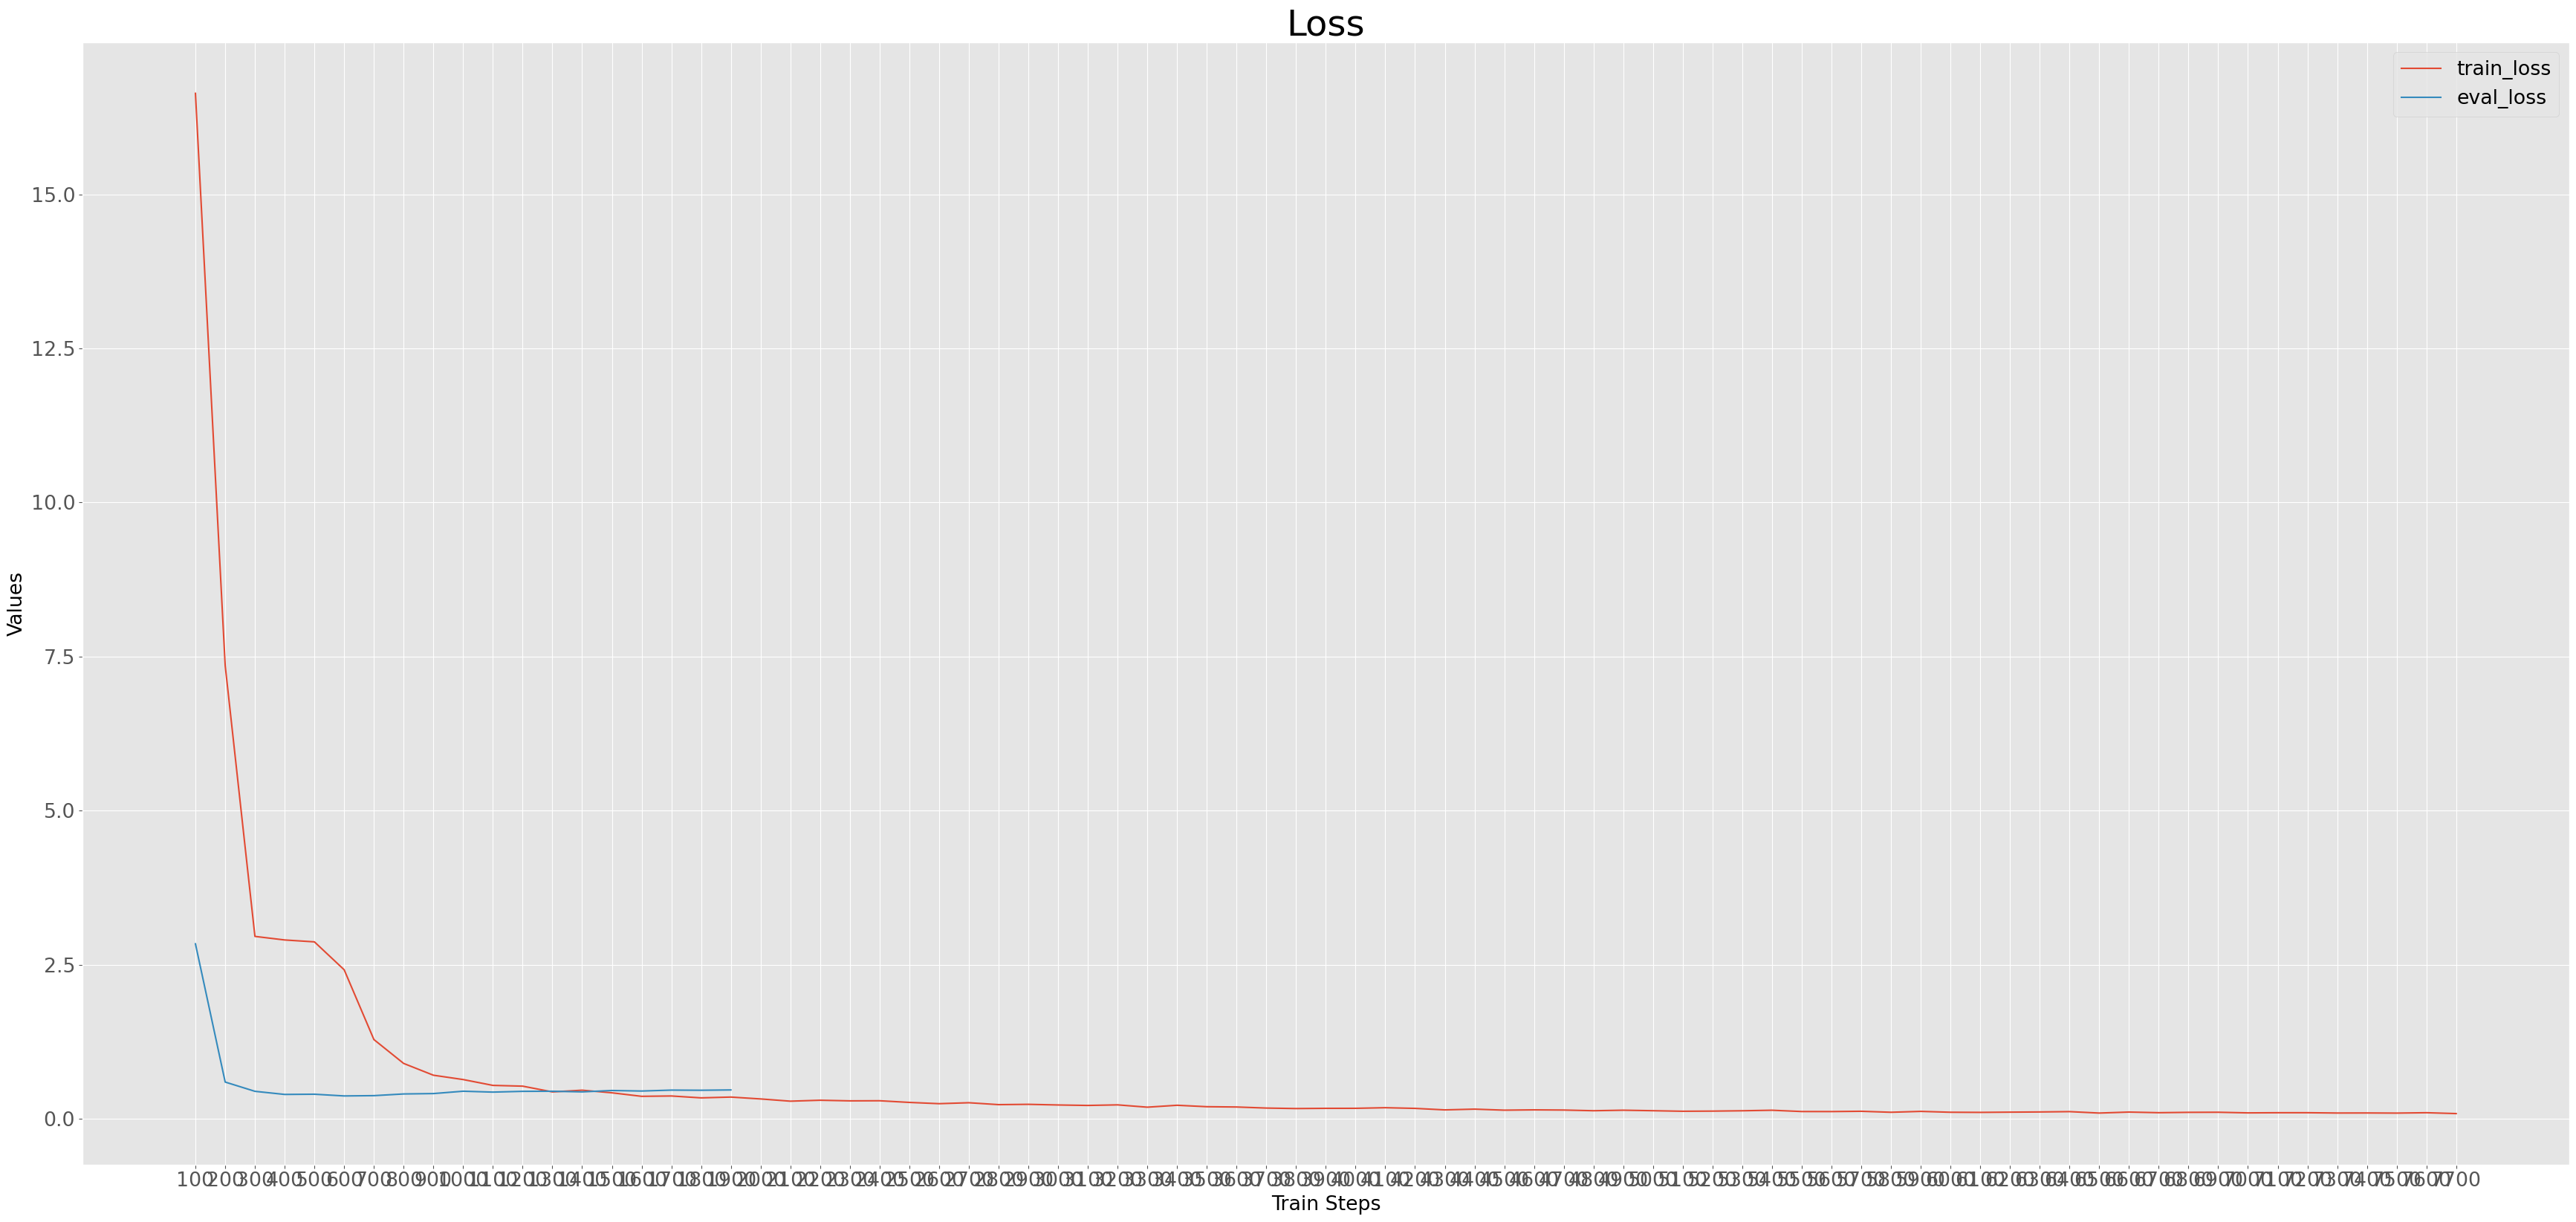

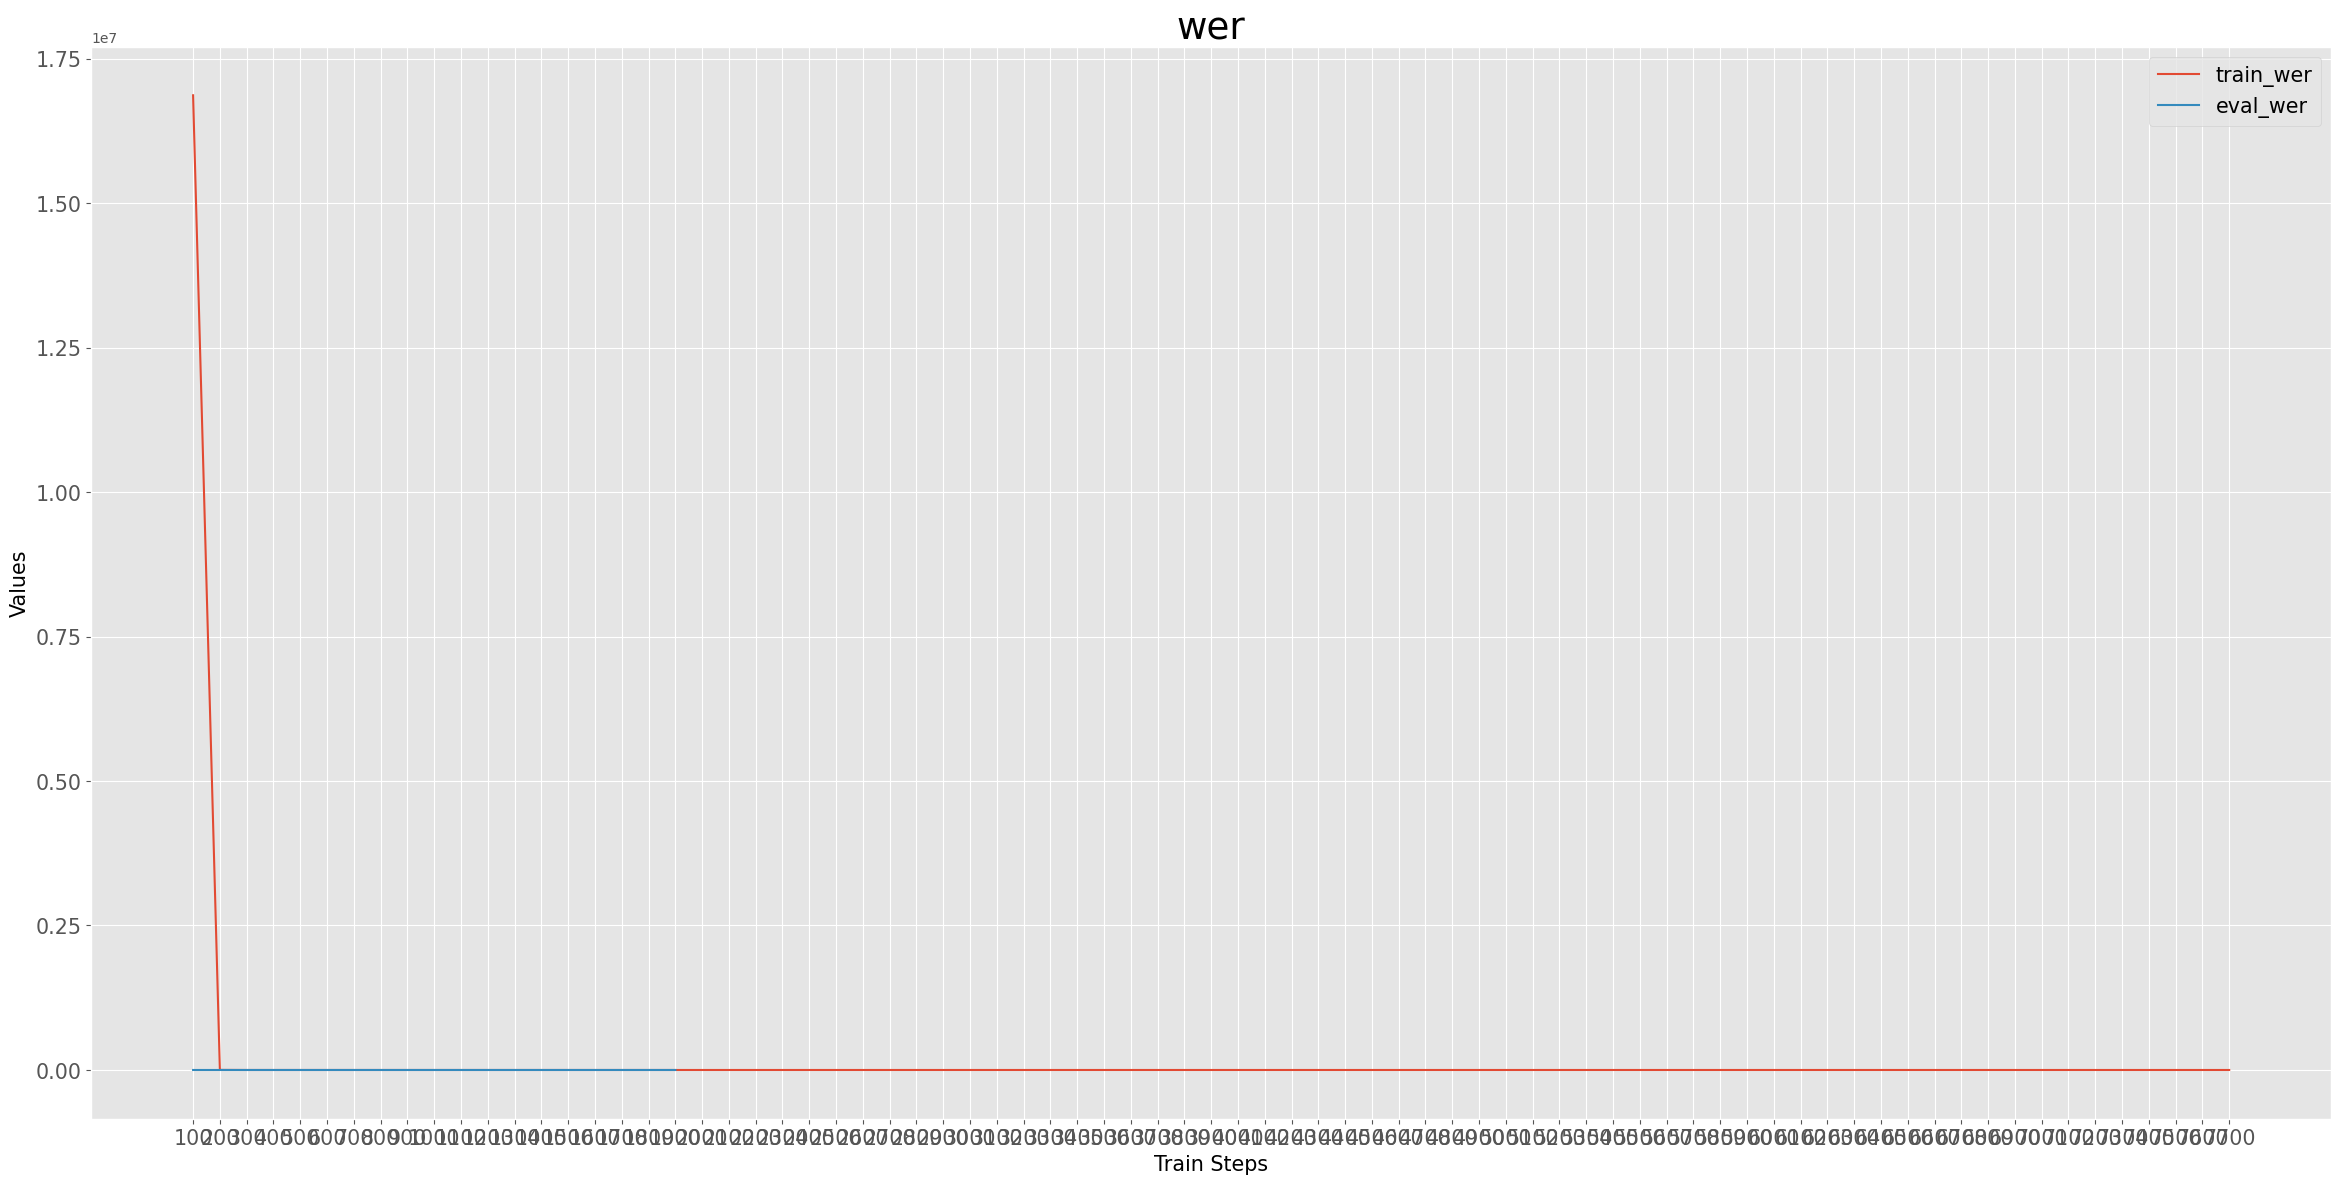

In [76]:
# Keep track of train and evaluate loss.
loss_history = {'train_loss':[], 'eval_loss':[]}
 
# Keep track of train and evaluate perplexity.
# This is a metric useful to track for language models.
wer_history = {'train_wer':[], 'eval_wer':[]}
 
# Loop through each log history.
for log_history in trainer.state.log_history:
 
  if 'loss' in log_history.keys():
    # Deal with trianing loss.
    loss_history['train_loss'].append(log_history['loss'])
    wer_history['train_wer'].append(math.exp(log_history['loss']))
     
  elif 'eval_loss' in log_history.keys():
    # Deal with eval loss.
    loss_history['eval_loss'].append(log_history['eval_loss'])
    wer_history['eval_wer'].append(math.exp(log_history['eval_loss']))
 
# Plot Losses.
plot_dict(loss_history, start_step=training_args.logging_steps, 
          step_size=training_args.logging_steps, use_title='Loss', 
          use_xlabel='Train Steps', use_ylabel='Values', magnify=0.3)
 
print()
 
# Plot Perplexities.
plot_dict(wer_history, start_step=training_args.logging_steps, 
          step_size=training_args.logging_steps, use_title='wer', 
          use_xlabel='Train Steps', use_ylabel='Values', magnify=0.2)

# Inference and Evaluation

We load the test split, re-splitted from our own data 

In [77]:
import os
import torch
from sklearn.model_selection import train_test_split
from datasets import load_dataset, load_metric,Dataset,concatenate_datasets,set_caching_enabled, ClassLabel
import pandas as pd

import random
from IPython.display import display, HTML

import json
from transformers import Wav2Vec2CTCTokenizer,Wav2Vec2ForCTC,Wav2Vec2Processor,Trainer,TrainingArguments,Wav2Vec2FeatureExtractor

import re
set_caching_enabled(False)

import soundfile as sf
import torchaudio


import IPython.display as ipd

import numpy as np
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

from tqdm import tqdm
import torch

Load pretrained model and processor to process the test dataset.

In [77]:
from transformers import Wav2Vec2ForCTC
model = Wav2Vec2ForCTC.from_pretrained("/home/ubuntu/model_output/lingala_xlsr/wav2vec2-large-xlsr-lingala/checkpoint-7600").to("cuda")
processor = Wav2Vec2Processor.from_pretrained("/home/ubuntu/model_output/lingala_xlsr/wav2vec2-large-xlsr-lingala")

loading configuration file /home/ubuntu/model_output/lingala_xlsr/wav2vec2-large-xlsr-lingala/checkpoint-7600/config.json
Model config Wav2Vec2Config {
  "_name_or_path": "facebook/wav2vec2-large-xlsr-53",
  "activation_dropout": 0.0,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForCTC"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 1,
  "classifier_proj_size": 256,
  "codevector_dim": 768,
  "contrastive_logits_temperature": 0.1,
  "conv_bias": true,
  "conv_dim": [
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "conv_kernel": [
    10,
    3,
    3,
    3,
    3,
    2,
    2
  ],
  "conv_stride": [
    5,
    2,
    2,
    2,
    2,
    2,
    2
  ],
  "ctc_loss_reduction": "mean",
  "ctc_zero_infinity": false,
  "diversity_loss_weight": 0.1,
  "do_stable_layer_norm": true,
  "eos_token_id": 2,
  "feat_extract_activation": "gelu",
  "feat_extract_dropout": 0.0,
  "feat_extract_norm": "layer",
  "feat_proj_dropout": 0.0,
  "feat_quantizer_

In [78]:
lingala_test.shape[0]

180

## Infer a few examples

In [79]:
input_dict = processor(lingala_test["input_values"][1],sampling_rate=16000, return_tensors="pt", padding=True)

logits = model(input_dict.input_values.to("cuda")).logits

pred_ids = torch.argmax(logits, dim=-1)[0]

In [80]:
print("Prediction:")
print(processor.decode(pred_ids))

#print(processor.decode(lingala_test["input_values"][0]))

print("\nReference:")
#print(common_voice_test_transcription["sentence"][0].lower())
print(processor.decode(lingala_test["labels"][1]))
#print("Target text:", lingala_test[0]["target_text"])

Prediction:
yango de lopango mudi yasombaki na mbɔngɔ tshotsho ayibaki

Reference:
yango nde lopango muji asombaki na mbɔngɔ tshotsho ayibaki


In [ ]:
inputs = processor(lingala_test["input_values"][1], sampling_rate=16_000, return_tensors="pt", padding=True)
with torch.no_grad():
    logits = model(inputs.input_values,).logits

pred_ids = torch.argmax(logits, dim=-1)

print("Prediction:", processor.batch_decode(pred_ids))
print("Reference:", lingala_test["labels"][1])

# Evaluate on test set

We evaluate the test set on WER with word boundaries and CER without spaces

In [81]:
final_pred = []
for i in tqdm(range(lingala_test.shape[0])):    
    input_dict = processor(lingala_test[i]["input_values"], return_tensors="pt", padding=True)

    logits = model(input_dict.input_values.to("cuda")).logits

    pred_ids = torch.argmax(logits, dim=-1)[0]
    prediction = processor.decode(pred_ids)
    final_pred.append(prediction)

  1%|          | 2/180 [00:00<00:20,  8.68it/s]It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
  3%|▎         | 5/180 [00:00<00:18,  9.60it/s]It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
  4%|▍         | 8/180 [00:00<00:18,  9.05it/s]It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the ``sampling_rate`` argument to this 

It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
 25%|██▌       | 45/180 [00:04<00:14,  9.06it/s]It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
 26%|██▌       | 47/180 [00:05<00:16,  8.21it/s]It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
 29%|██▉       | 52/180 [00:05<00:14,  9.09it/s]It is strongly recommended to pass the ``sampling_rate`` argument to th

 49%|████▉     | 88/180 [00:09<00:12,  7.33it/s]It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
 50%|█████     | 90/180 [00:09<00:11,  7.80it/s]It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
 51%|█████     | 92/180 [00:10<00:09,  9.07it/s]It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the ``sampling_rate`` argument to th

It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
 74%|███████▍  | 133/180 [00:14<00:06,  7.78it/s]It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
 77%|███████▋  | 138/180 [00:15<00:04,  8.77it/s]It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
 78%|███████▊  | 140/180 [00:15<00:03, 10.14it/s]It is strongly recommended to pass the ``sampling_rate`` argument to

It is strongly recommended to pass the ``sampling_rate`` argument to this function.Failing to do so can result in silent errors that might be hard to debug.
100%|██████████| 180/180 [00:19<00:00,  9.15it/s]


In [82]:
final_pred

['moyi ezalaki kongala makasi',
 'yango de lopango mudi yasombaki na mbɔngɔ tshotsho ayibaki',
 'mokimo ezali ekala',
 'aboyi kokεndε poto',
 'olobi ozali mwana ya barombu osilisi okeyi kaka bongo',
 'tshotsho asepeli',
 'here wana kimbaseque ezalaki mingi bamboka ya bacogo',
 'mingala mike miki pe epayi basi oyɔ ya mpεmbεni bango basengaka na ndege ya mokε te',
 'kitoko elɔkɔ teyemi',
 'nyɔnso wana ezosalama tshotshokodiongo mpe azoyeba te',
 'yɔka yɔ masolo ozalaka nango',
 'na nkoto mibale na zomi na sambo lopango ya suka etikalaki yango wana',
 'nakokεndε na ye wape soki balongoli ye',
 'ata pe ozali mwana barumbu osala nini',
 'afandaka lopango monene kaka ye moko',
 'nakozala te mokolo ko wikotelema',
 'palabala na kikwiti batongi te',
 'baye mona ete ezalaki kolobela moparo oyɔ azalaki na kati ya mesedes ya mwindu',
 'tika koloba boye',
 'tolangola mwa chere',
 'bakoma kobenga yɔ bon clian',
 'mibali oyɔ nyɔkolaki pe obomaki bazali bandeko na ngai',
 'bakozala kofuta mbɔngɔ na c

In [83]:
def map_to_result(batch):
  with torch.no_grad():
    input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  batch["text"] = processor.decode(batch["labels"], group_tokens=False)
  
  return batch


In [84]:
results = lingala_test.map(map_to_result, remove_columns=lingala_test.column_names)

  0%|          | 0/180 [00:00<?, ?ex/s]

In [85]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))


Test WER: 0.233


In [86]:
show_random_elements(results)


180


,pred_str,text
0,alingaka kotala baemission ya francais te,alingaka kotala baemission ya français te
1,bato bayei ebele esika yango mɔtɔ akoki pe kosunga bango ezali te,bato bayei ebele esika yango mɔtɔ akokipe kosunga bango azali te
2,tozalaki kobetana po na kolakisa makasi,tozalaki kobetana po na kolakisa makasi
3,akomi kaka koloba lisolo na litoyi ya makabu na ye oyɔ babimaki na ye,akomi kaka koloba lisolo na litoyi ya makangu na ye oyɔ babimaki na ye
4,kimya oyɔ ya ye,kimya oyɔ ya ye
5,naluki butu na moyi babengangai excellence ye oyɔ aleki na malonga,naluki butu na moyi babenga ngai excellence ye oyɔ aleki na malonga
6,soki kaka polele pawu,soki kaka polele pawu
7,bakozala kofuta mbɔngɔ na conte na ye ya banke,bakozala kofuta mbɔngɔ na compte na ye na banki
8,yɔ na mwasi na yɔ na bana na yɔ bolier yango,yɔ na mwasi na yɔ na bana na yɔ bolie yango
9,tshotshokodiongo apusani mpεmbεni na bango,tshotsho kodiongo apusani mpεmbεni na bango


In [ ]:
#model.to("cuda")

#with torch.no_grad():
#  logits = model(torch.tensor(lingala_test[:1]["input_values"], device="cuda")).logits

#pred_ids = torch.argmax(logits, dim=-1)

# convert ids to tokens
#" ".join(processor.tokenizer.convert_ids_to_tokens(pred_ids[0].tolist()))


In [101]:
wer_metric = load_metric("wer")
#cer_metric = load_metric("/home/ubuntu/cer")
cer_metric = load_metric("cer", revision="master")
#cer_metric = load_metric('cer')

Downloading:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

In [ ]:
#def compute_metrics(pred):
    #pred_logits = pred.predictions
    #pred_ids = np.argmax(pred_logits, axis=-1)

    #pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    #pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    #label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    # wer = wer_metric.compute(predictions=pred_str, references=label_str)
    # cer = fastwer.score(pred_str, label_str, char_level=True)
    #cer = word_error_rate(hypotheses=pred_str, references=label_str, use_cer=True)

    # ref: https://huggingface.co/ctl/wav2vec2-large-xlsr-cantonese/blob/main/cer.py
    #preds = [char for seq in pred_str for char in list(seq)]
    #refs = [char for seq in label_str for char in list(seq)]
    #cer = wer(refs, preds)

    #return {"cer": cer}
    # return {"wer": wer}

In [100]:
import evaluate
cer_metrics = evaluate.load("cer")

ModuleNotFoundError: No module named 'evaluator'

In [103]:
cer_metric.compute(predictions=results["pred_str"], references=results["text"])

0.06757530637956706

In [ ]:
cer_metric = load_metric("cer", revision="master")

In [104]:
print("Test CER: {:.3f}".format(cer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Test CER: 0.068
